AR composites (both anomaly/non-anomaly) of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

1. (upper) 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors
2. (precip) 
3. (ivt)
4. (slp)


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import independent_ttest, persistence

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/composites/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# 1) Upper level plots
upper_non_anom = {'name': 'huv250',
                  'anom': 'nanom',
                  'fname': 'ERA5/huvq/daily/out.era5_hma_05dg_daily_huvq_*.nc',
                  'bnds': [30., 120., 0., 65.],
                  'lev': 250.,
                  'cflevs': np.arange(40,131,10),
                  'cmap': 'BuPu',
                  'clevs': np.arange(840,1280,12),
                  'quiver_scale': 10,
                  'quiver_key': 25,
                  'quiver_key_lbl': r'25 m s$^{-1}$',
                  'cb_label': 'wind speed (kt)',
                  'fig_name_prefix': 'ar_types_upper_'}

upper_anom = {'name': 'huv250',
              'anom': 'anom',
              'fname': 'ERA5/huvq/anomalies/daily_filtered_anomalies_huvq_*.nc',
              'bnds': [30., 120., 0., 65.],
              'lev': 250.,
              'cflevs': np.arange(0,43,6),
              'cmap': 'BuPu',
              'clevs': np.arange(-10,11,2),
              'quiver_scale': 2,
              'quiver_key': 10,
              'quiver_key_lbl': r'10 m s$^{-1}$',
              'cb_label': 'wind speed (kt)',
              'fig_name_prefix': 'anom_ar_types_upper_'}

# 2) Precip Plots
precip_non_anom = {'name': 'prec',
                   'anom': 'nanom',
                   'fname': 'ERA5/prec/daily/out.era5_hma_025dg_daily_prec_*.nc',
                   'bnds': [40., 120., 10., 50.],
                   'cflevs': np.arange(2,22,2),
                   'cmap': cmo.rain,
                   'clevs': None,
                   'quiver_scale': None,
                   'quiver_key': None,
                   'quiver_key_lbl': None,
                   'cb_label': 'mm day-1',
                   'fig_name_prefix': 'ar_types_prec_'}

precip_anom = {'name': 'prec',
               'anom': 'anom',
               'fname': 'ERA5/prec/anomalies/daily_filtered_anomalies_*.nc',
               'bnds': [40., 120., 10., 50.],
               'cflevs': np.arange(-6,22,2),
               'cmap': cmocean.tools.crop(cmo.balance, vmin=-6., vmax=22., pivot=0., N=None, dmax=None),
               'clevs': None,
               'quiver_scale': None,
               'quiver_key': None,
               'quiver_key_lbl': None,
               'cb_label': 'mm day-1',
               'fig_name_prefix': 'anom_ar_types_prec_'}

# 3) IVT plots
ivt_non_anom = {'name': 'ivt',
                'anom': 'nanom',
                'fname': 'ERA5/ivt/daily/out.era5*.nc',
                'bnds': [30., 120., 0., 50.],
                'cflevs': np.arange(100,601,50),
                'cmap': cmo.deep,
                'clevs': None,
                'quiver_scale': 50,
                'quiver_key': 250,
                'quiver_key_lbl': r'250 kg m$^{-1}$ s$^{-1}$',
                'cb_label': 'kg m$^{-1}$ s$^{-1}$',
                'fig_name_prefix': 'ar_types_ivt_'}

ivt_anom = {'name': 'ivt',
            'anom': 'anom',
            'fname': 'ERA5/ivt/anomalies/daily_filtered_anomalies_*.nc',
            'bnds': [30., 120., 0., 50.],
            'cflevs': np.arange(10,180,10),
            'cmap': cmo.deep,
            'clevs': None,
            'quiver_scale': 10,
            'quiver_key': 25,
            'quiver_key_lbl': r'25 kg m$^{-1}$ s$^{-1}$',
            'cb_label': 'kg m$^{-1}$ s$^{-1}$',
            'fig_name_prefix': 'anom_ar_types_ivt_'}

## Possible choices for cEOF k-means - a) DJF b) MAM c) DJF-MAM
djf_dict = {'start_date': '1979-12-01',
             'end_date': '2018-02-28',
             'mon_s': 12,
             'mon_e': 2,
             'ys': 1979,
             'ye': 2018,
             'day_s': '01',
             'day_e': '28',
             'ssn': 'djf'}

# Option 2 - MAM only
mam_dict = {'start_date': '1979-03-01',
             'end_date': '2018-5-31',
             'mon_s': 3,
             'mon_e': 5,
             'ys': 1979,
             'ye': 2018,
             'day_s': '01',
             'day_e': '31',
             'ssn': 'mam'}

# Option 3 - DJF and MAM combined
djfmam_dict = {'start_date': '1979-03-01',
               'end_date': '2018-5-31',
               'mon_s': 12,
               'mon_e': 5,
               'ys': 1979,
               'ye': 2018,
               'day_s': '01',
               'day_e': '31',
               'ssn': 'djfmam'}



In [5]:
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict = precip_anom
# djf_dict mam_dict djfmam_dict
ar_dict = djfmam_dict

### ERA5 renalysis

In [6]:
# Select lat/lon grid
lonmin = plot_dict['bnds'][0]
lonmax = plot_dict['bnds'][1]
latmin = plot_dict['bnds'][2]
latmax = plot_dict['bnds'][3]

def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

# # open data
filepath_pattern = path_to_data + plot_dict['fname']   
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')

In [7]:

if plot_dict['name'] == 'huv250':
    var_dict = {'H': (['time', 'lat', 'lon'], f1['z'].values/(9.80665*10)), # convert to geopotential height (m)
                'U': (['time', 'lat', 'lon'], f1['u'].values),
                'V': (['time', 'lat', 'lon'], f1['v'].values)}
elif plot_dict['name'] == 'prec':
    var_dict = {'prec': (['time', 'lat', 'lon'], f1['mtpr'].values*86400)}
elif plot_dict['name'] == 'ivt':
    var_dict = {'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)}

ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f1.time.values),
                        'lat': (['lat'], f1.latitude.values),
                        'lon': (['lon'], f1.longitude.values)})
ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 6.04



### AR days

In [8]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-' + ar_dict['ssn'] + '.csv'
df = pd.read_csv(filepath)


In [9]:
# Trim date range
idx = slice(ar_dict['start_date'], ar_dict['end_date'])
ds = ds.sel(time=idx)

# Select DJF months
# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
else:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

In [10]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

In [11]:
# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)
era_ar_lead2 = select_ar_days(era=ds, lag=2)

# combine lag datasets into 1 ds object
era_ar_lag = xr.concat([era_ar_lead2, era_ar_lag0, era_ar_lag2], pd.Index([-2, 0, 2], name='lag'))
era_ar_lag

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 812)
Coordinates:
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
    ar       (time) int64 3 3 1 1 3 1 1 3 2 2 2 2 1 ... 3 2 3 3 1 1 1 1 3 3 2 1
Data variables:
    prec     (time, lat, lon) float64 -1.282 -1.27 -1.303 ... -0.8285 0.2274
<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 812)
Coordinates:
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
    ar       (time) int64 3 3 1 1 3 1 1 3 2 2 2 2 1 ... 3 2 3 3 1 1 1 1 3 3 2 1
Data variables:
    prec     (time, lat, lon) float64 -1.282 -1.311 -1.343 ... -3.692 -1.533 2.8
<xarray.Dataset>
Dimensi

<xarray.Dataset>
Dimensions:  (lag: 3, lat: 161, lon: 321, time: 812)
Coordinates:
    ar       (time) int64 3 3 1 1 3 1 1 3 2 2 2 2 1 ... 3 2 3 3 1 1 1 1 3 3 2 1
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lag      (lag) int64 -2 0 2
Data variables:
    prec     (lag, time, lat, lon) float64 -1.37 -1.36 -1.392 ... -1.533 2.8

### Compute AR Composites

In [12]:
# Count number of independent AR events

years = np.arange(ar_dict['ys'], ar_dict['ye']) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single season
    date1 = "{0}-{1}-{2}".format(years[k], ar_dict['mon_s'], ar_dict['day_s'])
    date2 = "{0}-{1}-{2}".format(years[k+1], ar_dict['mon_e'], ar_dict['day_e'])
    x = ds.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  181


In [13]:
# Compute composites of each AR type
era_ar_comp = era_ar_lag.groupby('ar').mean('time')

# run 1-sample t-test, mask results below 95% confidence level
if plot_dict['anom'] == 'anom':
    tval_mask, pval_mask = independent_ttest(ds=era_ar_lag, group='ar', alpha=0.05, df=total_events-2)
    era_ar_comp = era_ar_comp.where(tval_mask == True)
else:
    era_ar_comp = era_ar_comp


Critical t-value:  1.653410800122353


### Figures:

1. 0-Lag Composites (main, 3-panel)
2. 0-lag Composites w/ lags (supplementary, 9-panel)
3. Lag only composites (supplementary, 6-panel)

In [14]:
# 3-panel plot
panel_3 =  {'nrows': 3,
             'ncols': 1,
             'lag_lst': [0, 0, 0],
             'artype_lst': [1, 2, 3],
             'panel': '3pan'}

# 6-panel plot
panel_6 = {'nrows': 3,
            'ncols': 2,
            'lag_lst': [-2, -2, -2, 2, 2, 2],
            'artype_lst': [1, 2, 3, 1, 2, 3],
            'panel': '6pan'}
# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 3,
            'lag_lst': [-2, -2, -2, 0, 0, 0, 2, 2, 2],
            'artype_lst': [1, 2, 3, 1, 2, 3, 1, 2, 3],
            'panel': '9pan'}

panel_dict = [panel_3, panel_6, panel_9]

### Common Plot Properties

In [15]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)



### Upper Level Plots

In [ ]:
# loop through to create 3-panel, 6-panel, and 9-panel plot
for m in range(len(panel_dict)):
    fig_dict = panel_dict[m]
    
    filepath = path_to_figs + plot_dict['anom'] + '/' + 'HUV500_' + plot_dict['name']  + '_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'
    nrows = fig_dict['nrows']
    ncols = fig_dict['ncols']
    lag_lst = fig_dict['lag_lst']
    artype_lst = fig_dict['artype_lst']

    # Create figure
    fig = plt.figure(figsize=(15,10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.02, cbar_size='3%',label_mode='',
                    direction='column')

    # loop to draw plots
    for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
        data = era_ar_comp.sel(lag=lag, ar=ar_type)
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
        # Contour Filled

        # 250-hPa Winds (m/s)
        uwnd = data.U.values * units('m/s')
        vwnd = data.V.values * units('m/s')
        wspd = mpcalc.wind_speed(uwnd, vwnd)
        # 250-hPa Winds (knots)
        uwnd_kt = wspd.to('kt')
        vwnd_kt = wspd.to('kt')
        wspd_kt = wspd.to('kt')
        cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                         levels=plot_dict['cflevs'], cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
        # Contour Lines

        # 250-hPa Heights
        hgts = data.H.values
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=plot_dict['clevs'], colors='k', linewidths=1.1)
        plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                      color='k', regrid_shape=20, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
       # subtitles
        plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
        ax.set_title(plt_label, loc='left',fontsize=13)
    
    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

    # Save figure
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Show
    plt.show()


### IVT Plots

In [ ]:
# loop through to create 3-panel, 6-panel, and 9-panel plot
for m in range(len(panel_dict)):
    fig_dict = panel_dict[m]
    
    filepath = path_to_figs + plot_dict['anom'] + '/' + 'HUV500_' + plot_dict['name']  + '_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'    
    nrows = fig_dict['nrows']
    ncols = fig_dict['ncols']
    lag_lst = fig_dict['lag_lst']
    artype_lst = fig_dict['artype_lst']

    # Create figure
    fig = plt.figure(figsize=(15,10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.02, cbar_size='3%',label_mode='',
                    direction='column')

    # loop to draw plots
    for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
        data = era_ar_comp.sel(lag=lag, ar=ar_type)
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
        # Contour Filled
        
        # IVT (filled contour)
        uvec = data.ivte.values
        vvec = data.ivtn.values
        ivt = np.sqrt(uvec**2 + vvec**2)
        cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                         levels=plot_dict['cflevs'], cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=20, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
       # subtitles
        plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
        ax.set_title(plt_label, loc='left',fontsize=13)
    
    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

    # Save figure
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Show
    plt.show()


### Precip Plots

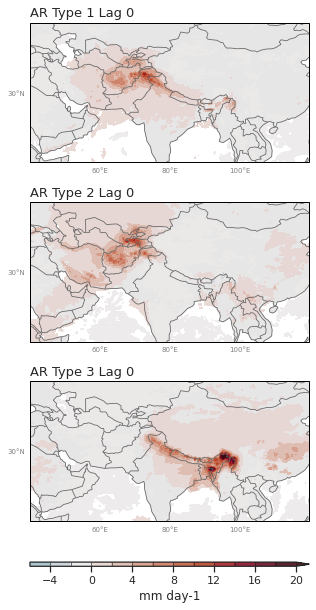

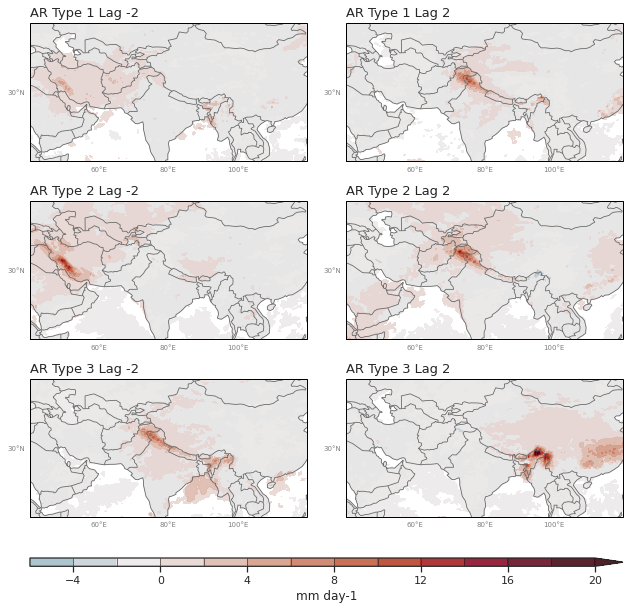

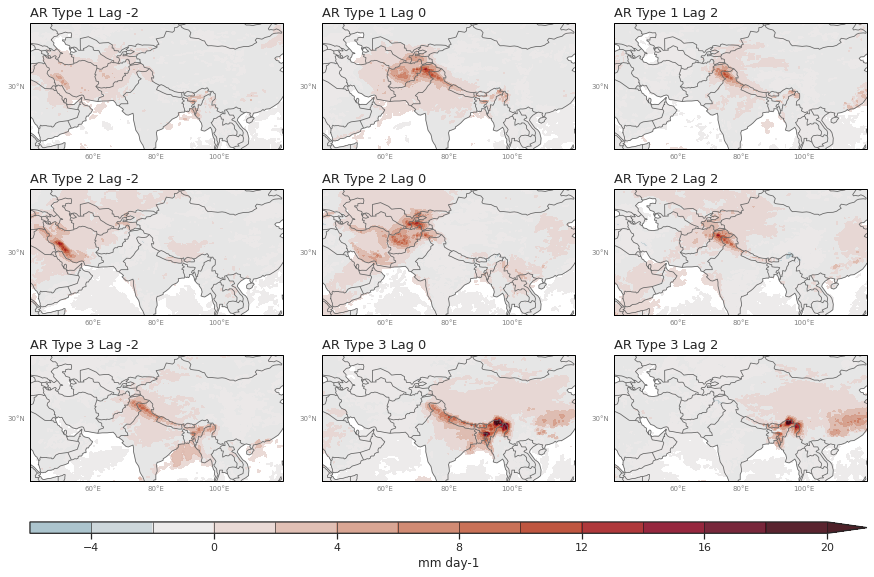

In [16]:
# loop through to create 3-panel, 6-panel, and 9-panel plot
for m in range(len(panel_dict)):
    fig_dict = panel_dict[m]
    
    filepath = path_to_figs + plot_dict['anom'] + '/' + 'HUV500_' + plot_dict['name']  + '_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'    
    nrows = fig_dict['nrows']
    ncols = fig_dict['ncols']
    lag_lst = fig_dict['lag_lst']
    artype_lst = fig_dict['artype_lst']

    # Create figure
    fig = plt.figure(figsize=(15,10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.02, cbar_size='3%',label_mode='',
                    direction='column')

    # loop to draw plots
    for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
        data = era_ar_comp.sel(lag=lag, ar=ar_type)
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
        # Contour Filled

        # Precip (filled contour)
        prec = data.prec.values
        cf = ax.contourf(lons, lats, prec, transform=datacrs,
                         levels=plot_dict['cflevs'], cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
       # subtitles
        plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
        ax.set_title(plt_label, loc='left',fontsize=13)
    
    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

    # Save figure
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Show
    plt.show()
